# Titanic: Machine Learning from Disaster

In [1]:
# download data from kaggle
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Simple data exploration

In [3]:
train = pd.read_csv(path/'train.csv')
train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- 177 values missing in `Age`
- 687 values missing in `Cabin`
- 2 values missing in `Embarked`

What correlates strongly with `Age`?

In [6]:
train.corrwith(train['Age']).abs().sort_values(ascending=False)

Age            1.000000
Pclass         0.369226
SibSp          0.308247
Parch          0.189119
Fare           0.096067
Survived       0.077221
PassengerId    0.036847
dtype: float64

- `Age` correlates perfectly with `Age`, as expected
- `Pclass` has the strongest correlation
- Fill missing `Age` values with the mean age for each particular `Pclass`

In [7]:
def fill_age(df):
    pclass = df.groupby(by='Pclass').mean()['Age']
    mapping = pclass.to_dict()
    df.loc[df['Age'].isnull(),'Age'] = df['Pclass'].map(mapping)
    
fill_age(train)

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.292875,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.210527,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Mean age changed from `29.699118` to `29.292875`

### Dealing with the `Cabin` column

In [9]:
train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [10]:
train['Cabin'].mode()[0]

'B96 B98'

- Most common `Cabin` entries are either `B96` or `B98`
- Fill missing values with `B96` (random choice)

In [11]:
def fill_cabin(df):
    df[['Cabin']] = df[['Cabin']].fillna(value=df['Cabin'].mode()[0])

fill_cabin(train)

### Dealing with the `Embarked` column

Same procedure as above. Filling missing values with the mode.

In [12]:
def fill_embarked(df):
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].mode()[0])

fill_embarked(train)

In [13]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

No more missing values.

### Data visualisation

<AxesSubplot:xlabel='Fare', ylabel='Count'>

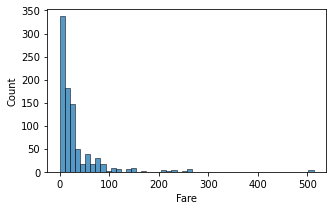

In [14]:
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(x='Fare', data=train, bins=50, ax=ax)

- `Fare` has a very large distribution - long tail to the right
- +1 because log(0) is undefined

<AxesSubplot:xlabel='LogFare', ylabel='Count'>

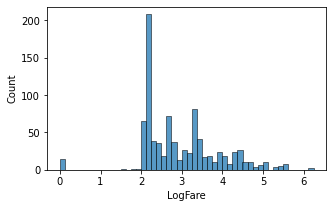

In [15]:
train['LogFare'] = np.log(train['Fare']+1)

fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(x='LogFare', data=train, bins=50, ax=ax)

Correlation maxtrix to visually see how features compare.

<AxesSubplot:>

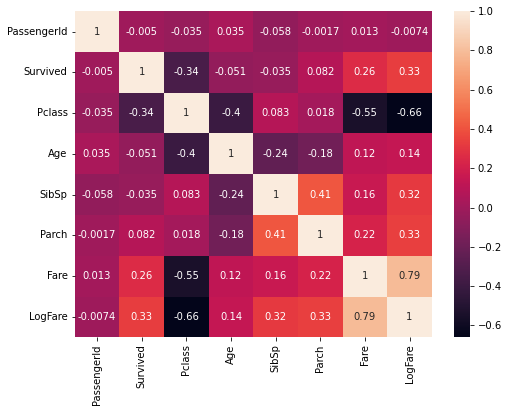

In [16]:
corr = train.corr()
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, ax=ax)

<AxesSubplot:xlabel='Survived', ylabel='count'>

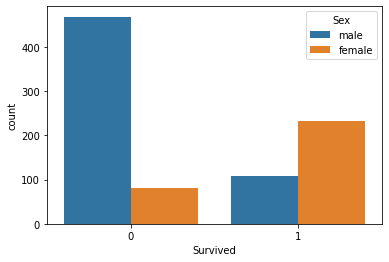

In [17]:
sns.countplot(x='Survived', hue='Sex', data=train)

In [18]:
num_of_males = (train['Sex'] == 'male').sum()
num_of_females = (train['Sex'] == 'female').sum()

males_survived = train.groupby('Sex')['Survived'].sum()['male']
females_survived = train.groupby('Sex')['Survived'].sum()['female']

print('% of males survived =', 100 * (males_survived / (num_of_females + num_of_males)))
print('% of females survived =', 100 * (females_survived / (num_of_females + num_of_males)))

% of males survived = 12.2334455667789
% of females survived = 26.15039281705948


- Figure above suggests more famles survived the Titanic disaster
- Quick calculation shows ~26% of females survived, while ~12% of males did

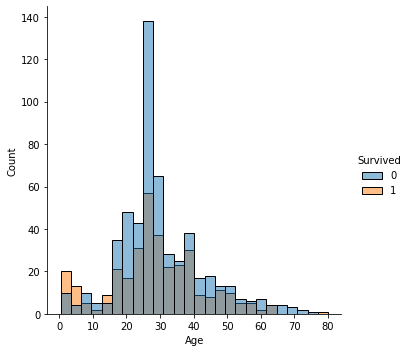

In [19]:
sns.displot(data=train, x='Age', hue='Survived')

- Simple data visualisation and understanding the data completed
- Building neural network from scratch

Using `pd.get_dummies()` to create dummy variables.

In [20]:
train = pd.get_dummies(train, columns=['Sex', 'Pclass', 'Embarked'])

In [21]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
train[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


- Create predictors and target variables as PyTorch tensors
- Independent variables are the continuous variables of interest plus the dummy variable from above

In [22]:
from torch import tensor
import torch, numpy as np

t_dep = tensor(train['Survived'])

indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(train[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([891, 12])

## Setting up the linear model

- Matrix of independent variables created
- Dependent variable vector created
- Calculate predictions and loss for a simple linear model first
- Random numbers in the range `(-0.5,0,5)`

In [23]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.2254,  0.1277, -0.2353, -0.0379,  0.4642, -0.1822, -0.4838, -0.1303,
        -0.4325,  0.2094,  0.0460,  0.0887])

- Predictions are calculated by multiplying each row of the coefficients and then summing them
- Dummy variables encapsulate the entire dataset and so no need for bias terms

In [24]:
t_indep * coeffs

tensor([[-4.9597,  0.1277, -0.0000,  ...,  0.0000,  0.0000,  0.0887],
        [-8.5668,  0.1277, -0.0000,  ...,  0.2094,  0.0000,  0.0000],
        [-5.8615,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0887],
        ...,
        [-5.6677,  0.1277, -0.4706,  ...,  0.0000,  0.0000,  0.0887],
        [-5.8615,  0.0000, -0.0000,  ...,  0.2094,  0.0000,  0.0000],
        [-7.2141,  0.0000, -0.0000,  ...,  0.0000,  0.0460,  0.0000]])

- `Age` is significantly larger than the other variables and will have a dominate the predictions
- Normalise `Age` by dividing by the `max()`

In [25]:
vals, indicies = t_indep.max(dim=0)
t_indep = t_indep / vals # dividing the matix by a vector
t_indep * coeffs

tensor([[-0.0620,  0.0160, -0.0000,  ...,  0.0000,  0.0000,  0.0887],
        [-0.1071,  0.0160, -0.0000,  ...,  0.2094,  0.0000,  0.0000],
        [-0.0733,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0887],
        ...,
        [-0.0708,  0.0160, -0.0784,  ...,  0.0000,  0.0000,  0.0887],
        [-0.0733,  0.0000, -0.0000,  ...,  0.2094,  0.0000,  0.0000],
        [-0.0902,  0.0000, -0.0000,  ...,  0.0000,  0.0460,  0.0000]])

Calculate predictions by adding up the rows of the product.

In [26]:
preds = (t_indep * coeffs).sum(axis=1)

In [27]:
preds.shape

torch.Size([891])

- Predictions were calculated from random coefficients
- Create loss function for gradient descent
- Loss function: take average error of the rows - absolute value of the difference between the prediction and the dependent variable

In [28]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.6281)

- Create functions for calculating the predicitions and the loss

In [29]:
def calc_preds(coeffs, indeps):
    return (indeps * coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

### Gradient descent of one epoch
- Use PyTorch, `requires_grad_()` on `coeffs` to do a single gradient descent epoch

In [30]:
coeffs.requires_grad_()

tensor([-0.2254,  0.1277, -0.2353, -0.0379,  0.4642, -0.1822, -0.4838, -0.1303,
        -0.4325,  0.2094,  0.0460,  0.0887], requires_grad=True)

Calculate loss and PyTorch should keep track of all the steps and so the gradient can be retrieved using `backward()`.

In [31]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6281, grad_fn=<MeanBackward0>)

In [32]:
loss.backward()

Examine the coefficients.

In [33]:
coeffs.grad

tensor([-0.1032, -0.0149, -0.0423, -0.1493,  0.1358, -0.3524, -0.1975, -0.0022,
        -0.0168, -0.0539, -0.0617, -0.1010])

Everytime `backward()` is called, the gradients are added to the `.grad` attribute.

In [34]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.2064, -0.0297, -0.0845, -0.2985,  0.2716, -0.7048, -0.3951, -0.0045,
        -0.0337, -0.1077, -0.1235, -0.2020])

After using the gradients for gradient descent, they must be reset back to zero.

In [35]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5618)


Train a linear model and use `RandomSplitter` from `fastai.data.transforms` to hold out a validation set for calculating metrics.

In [36]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter()(train)

Apply indicies to the independent and dependent variables.

In [37]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

Wrap it all up in a function.

In [38]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [39]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [40]:
def init_coeffs(): 
    return (torch.rand(n_coeff)-0.5).requires_grad_()

Use functions to train the model.

In [41]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

coeffs = train_model(20, lr=0.2)

0.533; 0.496; 0.470; 0.447; 0.423; 0.400; 0.378; 0.363; 0.349; 0.350; 0.312; 0.316; 0.301; 0.306; 0.284; 0.285; 0.279; 0.283; 0.268; 0.267; 

Coefficients are decreasing - model is training.

In [42]:
def show_coeffs(): 
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2944),
 'SibSp': tensor(0.0852),
 'Parch': tensor(0.2299),
 'LogFare': tensor(-0.0031),
 'Sex_male': tensor(-0.4927),
 'Sex_female': tensor(0.2861),
 'Pclass_1': tensor(0.6744),
 'Pclass_2': tensor(0.4454),
 'Pclass_3': tensor(0.3326),
 'Embarked_C': tensor(0.1185),
 'Embarked_Q': tensor(0.2512),
 'Embarked_S': tensor(0.1353)}

Measuring the accuracy.

Accuracy - proportion of rows where model correctly predict survival.

In [43]:
preds = calc_preds(coeffs, val_indep)

A score over `0.5` is predicted to survive. Below `0.5` did not survive.

In [44]:
results = val_dep.bool()==(preds>0.5)
results

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True, False, False,  True,  True,  True, False, False,  True,
        False,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True, False, False,  True, False,
         True, False,  True, False,  True,  True,  True,  True, False, False,
         True,  True,  True,  True, False,  True,  True, False, False,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True, False,  True, False, False,  True,  True,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True, 

In [45]:
results.float().mean()

tensor(0.7191)

~80% accuracy. Wrap it all in a function.

In [46]:
def acc(coeffs): 
    return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7191)

### Using a sigmoid function to improve accuracy

The main reason why we use sigmoid function is because it exists between (0 to 1). Therefore, it is especially used for models where we have to predict the probability as an output. Since probability of anything exists only between the range of 0 and 1, sigmoid is the right choice.

Below is a plot of the function.

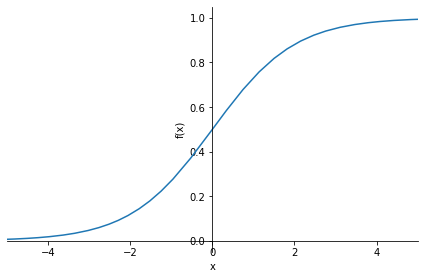

In [47]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5))

In [48]:
# using sigmoid from PyTorch
def calc_preds(coeffs, indeps): 
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

Train model with sigmoid function.

In [49]:
coeffs = train_model(lr=100)

0.512; 0.309; 0.289; 0.203; 0.185; 0.182; 0.182; 0.181; 0.181; 0.180; 0.180; 0.180; 0.180; 0.179; 0.179; 0.179; 0.179; 0.179; 0.179; 0.179; 0.179; 0.179; 0.179; 0.178; 0.178; 0.178; 0.178; 0.178; 0.178; 0.178; 

In [50]:
acc(coeffs)

tensor(0.7640)

Improvement on accuracy when compared with the previous approach.